<a href="https://colab.research.google.com/github/RolandTapie/Data_Projects/blob/main/Data_science/Bank/Modele_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Montage du Drive**

In [370]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#**PDF**

In [371]:
!pip install reportlab
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle

In [372]:
# Nom du fichier PDF
file_name = "/content/drive/My Drive/rapport.pdf"

# Créer un document PDF avec le format A4
pdf = SimpleDocTemplate(file_name, pagesize=A4)

# Styles de texte
styles = getSampleStyleSheet()
title_style = styles['Title']
normal_style = styles['Normal']

# Contenu du rapport
content = []

# Titre du rapport
title = Paragraph("Rapport d'Activités", title_style)
content.append(title)

# Ajouter un espace
content.append(Spacer(1, 0.5 * inch))

# Paragraphe d'introduction
intro_text = "Ce rapport présente les activités et les résultats obtenus durant la période concernée."
content.append(Paragraph(intro_text, normal_style))

# Ajouter un autre espace
content.append(Spacer(1, 0.5 * inch))

# Table des données
table_data = [
    ["Activité", "Description", "Résultat"],
    ["Activité 1", "Description de l'activité 1", "Succès"],
    ["Activité 2", "Description de l'activité 2", "En cours"],
    ["Activité 3", "Description de l'activité 3", "Échec"]
]

# Créer une table
table = Table(table_data)

# Ajouter des styles à la table
table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))

# Ajouter la table au contenu
content.append(table)

# Générer le PDF
pdf.build(content)

print(f"Rapport généré avec succès : {file_name}")

Rapport généré avec succès : /content/drive/My Drive/rapport.pdf


# **Fonction**

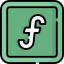

In [373]:
def summary(liste,section,libelle,valeur):
  liste.append([len(liste)+1,section,libelle,valeur])
  return (liste)

def print_summary(data):
  headers = data[0]
  table_data = data[1:]
  titre="RESULTATS: analyses et Modélisation"
  titre=titre.center(100,"=")
  print("*"* len(titre))
  print(titre)
  print("*"* len(titre))
  print(tabulate(table_data, headers, tablefmt="grid"))

  table_str = titre + "\n" +tabulate(table_data, headers, tablefmt="grid")

  output_file = "/content/drive/My Drive/colab_table_a4_format.txt"

  # Write the formatted table to a .txt file
  with open(output_file, "w") as file:
      file.write(table_str)

  print(f"Table saved to {output_file}")


# **Import des packages**

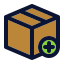

In [374]:
#!pip install nxviz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#import nxviz as nv
import missingno as msno
from itertools import combinations
from tabulate import tabulate
import os

from scipy.stats import iqr, shapiro,kstest
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score,roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score,f1_score,accuracy_score,precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import qqplot
import numpy as np


# **Configuration**

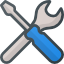

In [375]:
cible="Survived"
cible="Class"
cible="response_binary"
cible="Survived"

Kaggle=True
Kaggle_train="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/train.csv"
Kaggle_test="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/test.csv"

validation_croisee=True

resume=[]
resume=summary(resume,"Section","libelle","information")

col_del=[]
cat_ordi=[]

pca=False
dim_pca=0
var_pca=0.95

predictions=[]
recall={}
accuracy={}
f1score={}
precision={}

alpha=0.05
fraction=0 #0.2
seed=55
corr_limit=0.4
fold=3


modeles={
    "logreg":LogisticRegression(solver='lbfgs', max_iter=100),
    "knn":KNeighborsClassifier(n_neighbors=5),
    "tree":DecisionTreeClassifier(random_state=0)
    }

modeles_grid={
    "logreg":{
        'C': [0.1, 1, 10, 100],  # Force de régularisation (inverse de λ)
        'penalty': ['l1', 'l2', 'elasticnet', None],  # Types de régularisation
        'solver': ['lbfgs'],  # Algorithmes d'optimisation
        'l1_ratio': [0, 0.5, 1]  # Utilisé uniquement avec elasticnet},
            },
    "knn":{
        'n_neighbors': [3, 5, 7, 9],          # Nombre de voisins
        'weights': ['uniform', 'distance'],   # Poids uniformes ou inversement proportionnels à la distance
        'metric': ['euclidean', 'manhattan', 'minkowski'],  # Type de distance
        'p': [1, 2]  # Valeur de 'p' pour la distance Minkowski (1 = Manhattan, 2 = Euclidienne)},
          },
    "tree":{
        'criterion': ['gini', 'entropy'],       # Fonction pour mesurer la qualité du split
        'splitter': ['best', 'random'],         # Stratégie pour choisir la variable de split
        'max_depth': [3, 5, 10, None],          # Profondeur maximale de l'arbre
        'min_samples_split': [2, 5, 10],        # Nombre minimum d'échantillons pour diviser un nœud
        'min_samples_leaf': [1, 2, 4],          # Nombre minimum d'échantillons dans une feuille
        'max_features': [None, 'auto', 'sqrt', 'log2']  # Nombre maximum de caractéristiques pour les splits}
      }
}


file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/train.csv"
file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/titanic_data_simplified.csv"
file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/Raisin_Dataset.csv"







resume=summary(resume,"Configuration","Seuil d'acceptabilité des hypothèses  : ",alpha)
resume=summary(resume,"Configuration","Fraction de la base de test : ",fraction)
resume=summary(resume,"Configuration","Seed : ",seed)
resume=summary(resume,"Configuration","Limite de corrélation : ",corr_limit)
resume=summary(resume,"Configuration","Modele : ",modeles)
resume=summary(resume,"Dataset","Chemin du fichier : ",file_path)
resume=summary(resume,"Dataset","Cible : ",cible)

**Montage du drive**

In [376]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# **Lecture du dataset**

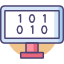

In [377]:
df = pd.read_csv(Kaggle_train)
df_test=pd.read_csv(Kaggle_test)
df_test_s=pd.read_csv(Kaggle_test)

resume=summary(resume,"Dataset","Path",file_path)

In [378]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#**Data Preprocessing**

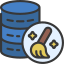

##**Renommage des colonnes**

In [379]:

feat=['age', 'job', 'marital', 'education', 'default','balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign','pdays', 'previous', 'poutcome', 'response_binary']
feat=['age', 'balance','duration', 'campaign','pdays','loan']
one_hot_enconding=["job","marital","education","default","housing","loan","month","poutcome"]
one_hot_enconding=['loan']


##**Définir la cible**

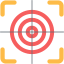

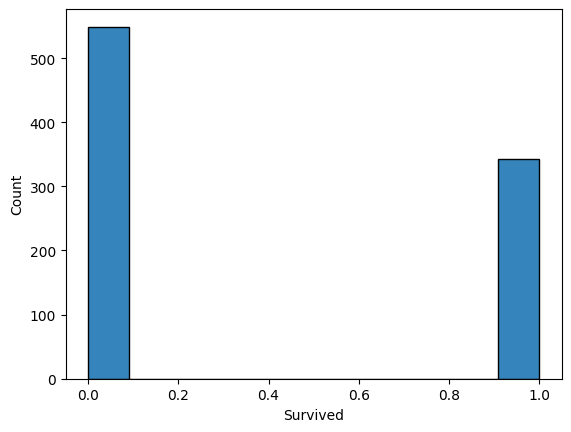

2


In [380]:
df_cible=df[cible].value_counts()
sns.histplot(data=df,x=cible,alpha=0.9)
#df_cible.plot(kind="bar")
plt.show()
print(len(df_cible))
if (len(df_cible)==2):
  resume=summary(resume,"Dataset","Nature cible", "Cible binaire -> Classification")
elif (len(df_cible)>2):
  resume=summary(resume,"Dataset","Nature cible", "Cible non binaire -> Régression")
else:
  resume=summary(resume,"Dataset","Nature cible", "Vérifier la cible")
  raise ValueError("Vérifier la cible")

## **Description du dataset**

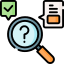

In [381]:
df.describe()
resume=summary(resume,"Dataset","taille", str(len(df)) + " observations")

In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## **Particularités du Dataset   /!\**

###**Feature Engineering**

## **Traiter le type des données**

In [383]:
for col in df.columns:
  if "Unnamed" in col:
    df=df.drop(col,axis=1)
    df_test=df_test.drop(col,axis=1)
  if "Emoji" in col:
    df=df.drop(col,axis=1)
    df_test=df_test.drop(col,axis=1)
  if "Name" in col:
    df=df.drop(col,axis=1)
    df_test=df_test.drop(col,axis=1)
  if "Ticket" in col:
    df=df.drop(col,axis=1)
    df_test=df_test.drop(col,axis=1)
  if "Cabin" in col:
    df=df.drop(col,axis=1)
    df_test=df_test.drop(col,axis=1)
  if 'PassengerId' in col:
    df=df.drop(col,axis=1)
    df_test=df_test.drop(col,axis=1)


colonnes=df.columns.tolist()

print("Les champs du Dataset")
print(colonnes)
compteur=0
for col in colonnes:
  if df[col].dtype=="object":
    df[col]=df[col].astype("category")
    compteur+=1

    print(f'les données du champ {col} de type {df[col].dtype} ont été changées en type category')
    print('\n')
    print('Avec les valeurs ci-dessous:')
    print('\n')
    print(df[col].unique())
    print('\n')
resume=summary(resume,"Dataset","Nombre de champs de type object tranformés en category",compteur)

liste_cat=[col for col in df.columns if df[col].dtype=="category"]

resume=summary(resume,"Dataset","Nombre de champs de type category",compteur)
liste_float_int=[col for col in df.columns if ((df[col].dtype=="int64")|(df[col].dtype=="float64"))]

print("*"*100)
print('la liste des champs de type float ou int')
print (liste_float_int)
resume=summary(resume,"Dataset","champs de type float ou int",(liste_float_int))
print("*"*100)
print('la liste des champs de type category')
print (liste_cat)
resume=summary(resume,"Dataset","champs de type category",(liste_cat))

Les champs du Dataset
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
les données du champ Sex de type category ont été changées en type category


Avec les valeurs ci-dessous:


['male', 'female']
Categories (2, object): ['female', 'male']


les données du champ Embarked de type category ont été changées en type category


Avec les valeurs ci-dessous:


['S', 'C', 'Q', NaN]
Categories (3, object): ['C', 'Q', 'S']


****************************************************************************************************
la liste des champs de type float ou int
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
****************************************************************************************************
la liste des champs de type category
['Sex', 'Embarked']


## **Vérification des enrigistrements nulls**

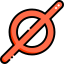

In [384]:
df.isna().any().sum()
resume=summary(resume,"Dataset","Nombre de valeurs nulles",df.isna().any().sum())
for col in liste_float_int:
  if (col!=cible):
    df[col]=df[col].fillna(df[col].mean())
    df_test[col]=df_test[col].fillna(df_test[col].mean())

for col in liste_cat:
  if (col!=cible):
    df[col]=df[col].fillna(df[col].mode()[0])
    df_test[col]=df_test[col].fillna(df_test[col].mode()[0])

df.dropna(inplace=True)
df_test.dropna(inplace=True)

## **Vérification des doublons**

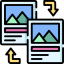

In [385]:
df.duplicated().sum()
resume=summary(resume,"Dataset","Nombre de doublons",df.duplicated().sum())
df_test.duplicated().sum()

38

<Figure size 100x100 with 0 Axes>

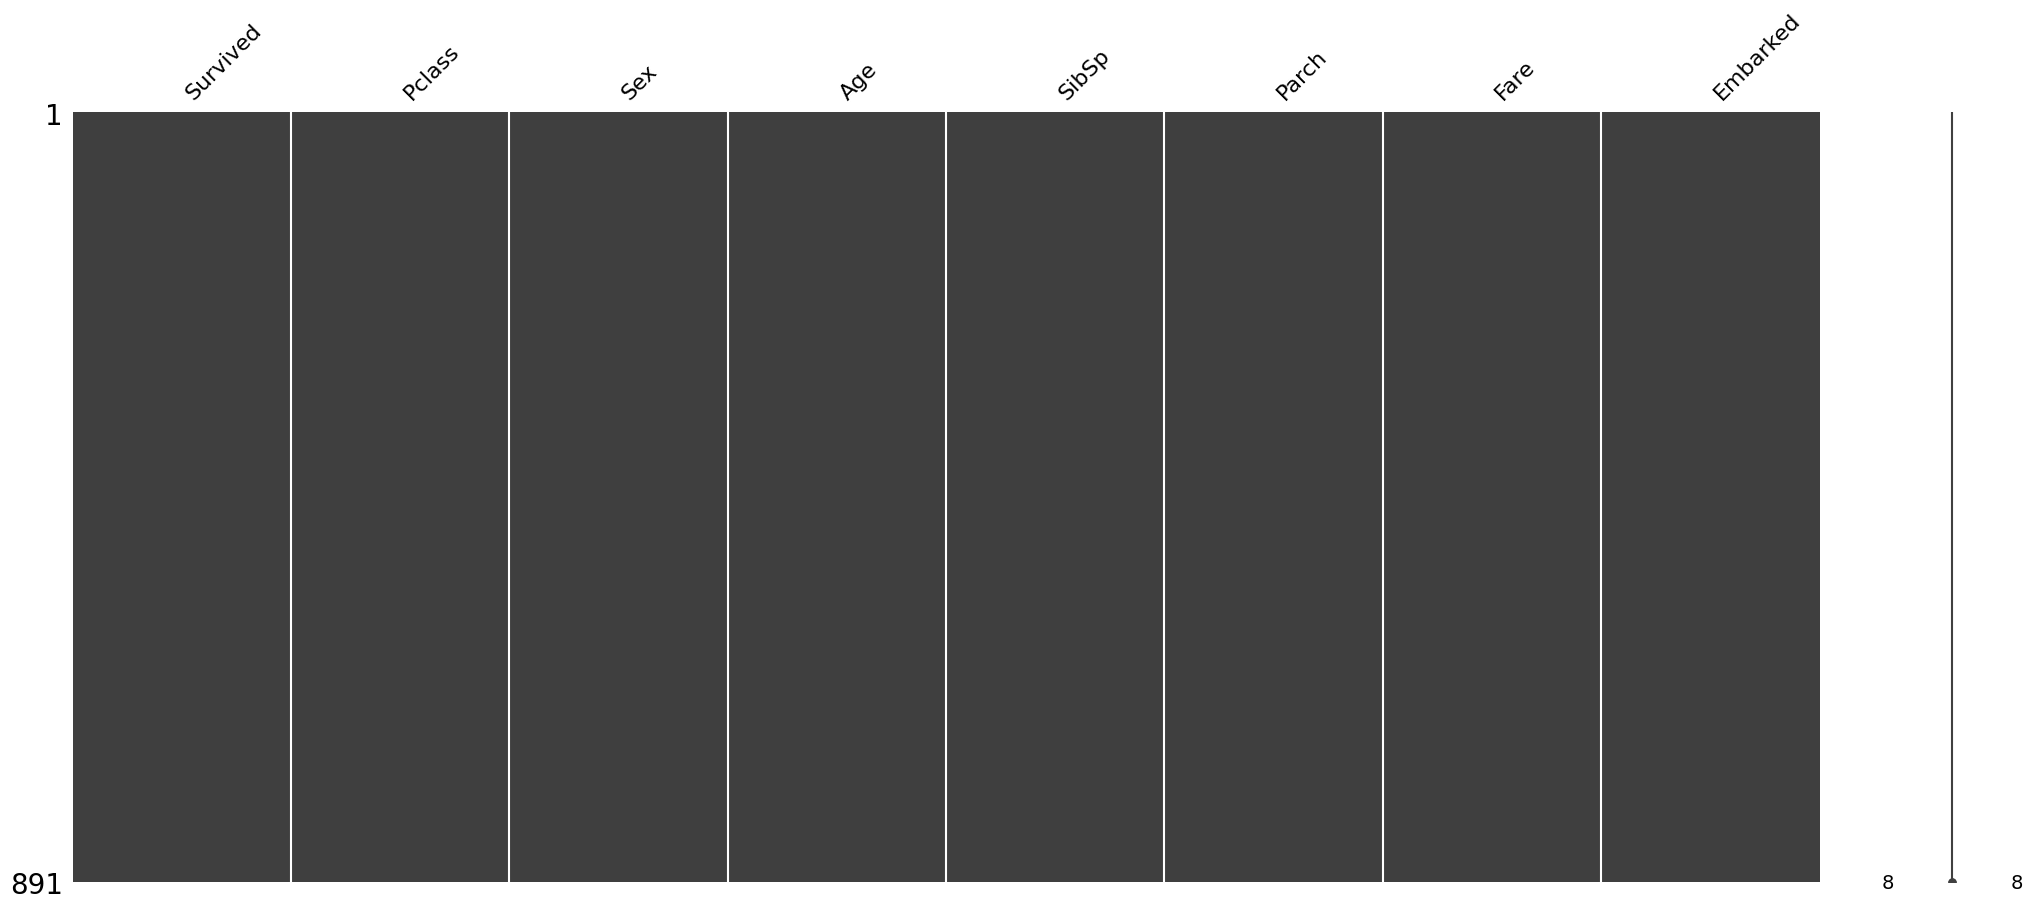

In [386]:
plt.figure(figsize=(1, 1))
msno.matrix(df)
plt.show()

In [387]:
# Supprimer les lignes où toutes les valeurs sont manquantes
df= df.dropna(how='all')

# **EDA : Analyse Exploratoire des Données**

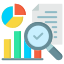

## **Analyse des données catégorielles**

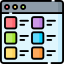

<ipython-input-388-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


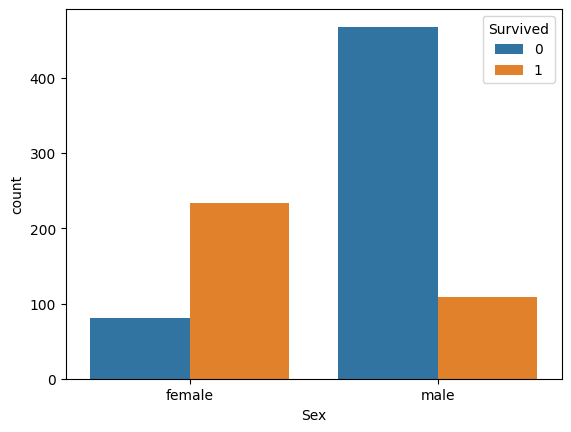

****************************************************************************************************
Sex
male      0.65
female    0.35
Name: proportion, dtype: float64


<ipython-input-388-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


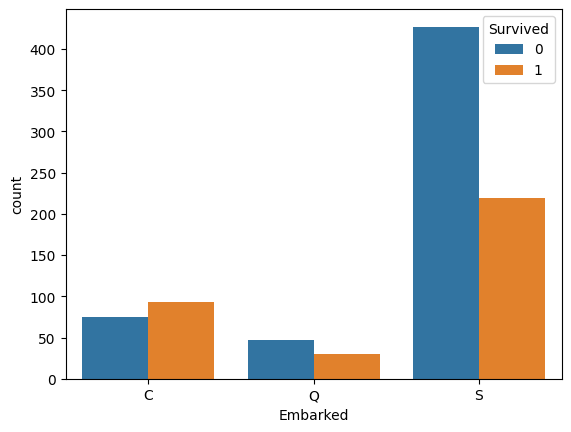

****************************************************************************************************
Embarked
S    0.73
C    0.19
Q    0.09
Name: proportion, dtype: float64


In [388]:
df_cat=df[liste_cat]
analyse=""
for col in liste_cat:
  #print(df_cat[col].value_counts(normalize=True))
  analyse=analyse+col+'\n'
  analyse=analyse+("*"*10)+'\n'
  analyse=analyse+str(df_cat[col].value_counts(normalize=True).round(2))+'\n'
  #df_cat[col].value_counts(normalize=True).plot(kind='bar')

  counts = df.groupby([col, cible]).size().reset_index(name='count')

  sns.barplot(data=counts, x=col, y='count', hue=cible)
  plt.show()
  print("*"*100)
  print(df_cat[col].value_counts(normalize=True).round(2))
resume=summary(resume,"EDA","Analyse des données catégorielles",analyse)

## **Vérifications des distributions**

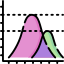



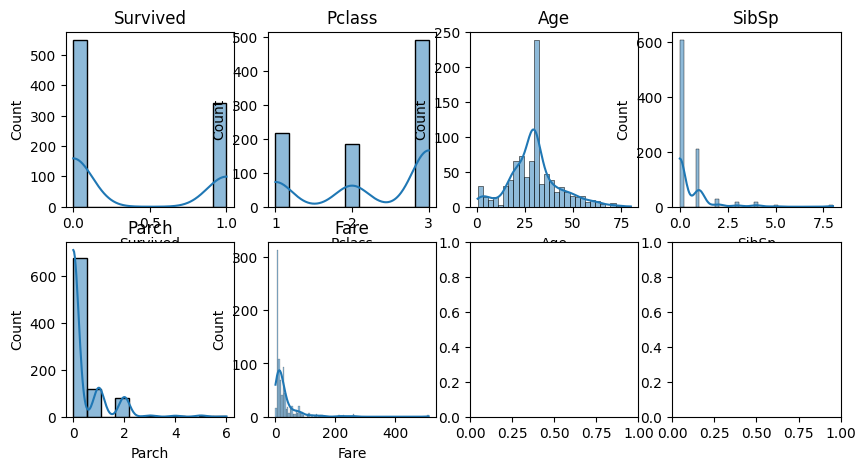

In [389]:
size=len(liste_float_int)
fig, axes = plt.subplots((size//4)+1, 4, figsize=(10, 5))
axes=axes.flatten()

for col in liste_float_int:
  sns.histplot(df[col],ax=axes[liste_float_int.index(col)], kde=True)
  axes[liste_float_int.index(col)].set_title(col)

plt.show()

##**Test sur la normalité des données numériques**:


*   Shapiro
*   Kolgomorov-Smirnov
* QQplot



### **Test de Shapiro**
Test de Shapiro-Wilk : Vérifie si les données suivent une distribution normale.

Utilisé pour des tests d'hypothèse paramétriques (comme les tests t).
Python : scipy.stats.shapiro

In [390]:

liste_norm=""
for col in liste_float_int:
  stats, p_value = shapiro(df[col])
  stats=round(stats,3)
  p_value=round(p_value,3)
  if p_value>alpha:
    liste_norm=liste_norm+col+f" : p_value ({p_value} > alpha ({alpha})) Non rejet de H0 > les données suivent une distribution normale"+'\n'
  else:
    liste_norm=liste_norm+col+f" : p_value ({p_value} < alpha ({alpha})) Rejet de H0 > les données ne suivent pas une distribution normale"+'\n'
  print(col,stats, p_value)

resume=summary(resume,"EDA","Distribution normale des données (Test de Shapiro Wilk)",f"Mise en place des hypothèses (alpha) = {(alpha)}:" +"\n" \
               + "H0 > (les données suivent une distribution normale)" +"\n"+ "H1 > (les données ne suivent pas une distribution normale) \n"\
               +"\n"\
               + liste_norm)

Survived 0.617 0.0
Pclass 0.718 0.0
Age 0.959 0.0
SibSp 0.513 0.0
Parch 0.533 0.0
Fare 0.522 0.0


### **Test de Kolmogorov-Smirnov**
Test de Kolmogorov-Smirnov (KS) : Compare un échantillon à une distribution théorique (comme la normale).

Python : scipy.stats.kstest

In [391]:
liste_norm=""
for col in liste_float_int:
  stats, p_value = kstest(df[col],'norm')
  stats=round(stats,3)
  p_value=round(p_value,3)
  if p_value>alpha:
    liste_norm=liste_norm+col+f" : p_value ({p_value} > alpha ({alpha})) Non rejet de H0 > les données suivent une distribution normale"+'\n'
  else:
    liste_norm=liste_norm+col+f" : p_value ({p_value} < alpha ({alpha})) Rejet de H0 > les données ne suivent pas une distribution normale"+'\n'
  print(col,stats, p_value)

resume=summary(resume,"EDA","Distribution normale des données (Test de Kolgomorov-Smirnov)",f"Mise en place des hypothèses (alpha) = {(alpha)}:" +"\n" \
               + "H0 > (les données suivent une distribution normale)" +"\n"+ "H1 > (les données ne suivent pas une distribution normale) \n"\
               +"\n"\
               + liste_norm)

Survived 0.5 0.0
Pclass 0.841 0.0
Age 0.972 0.0
SibSp 0.5 0.0
Parch 0.5 0.0
Fare 0.983 0.0


### **Test Anderson-Darling**
Test d'Anderson-Darling : Teste si les données suivent une distribution spécifique (meilleur que Shapiro pour des tailles d'échantillons importantes).

Python : scipy.stats.anderson

### **QQplot**

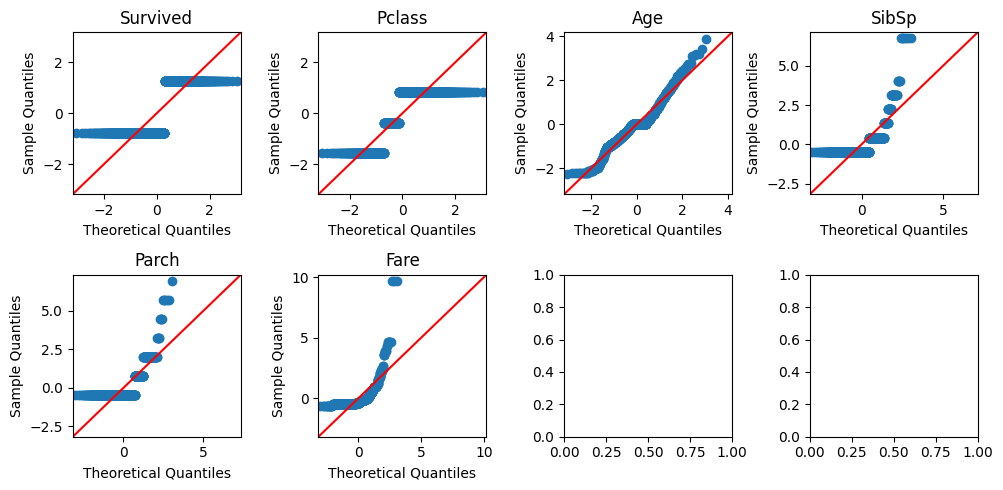

In [392]:
size=len(liste_float_int)
fig, axes = plt.subplots((size//4)+1, 4, figsize=(10, 5))
axes=axes.flatten()

for col in liste_float_int:
  qqplot(df[col], fit=True, line="45",ax=axes[liste_float_int.index(col)])
  axes[liste_float_int.index(col)].set_title(col)

plt.tight_layout()
plt.show()

resume=summary(resume,"EDA","Vérification Visuelle de la normalité",f"Vérification Visuelle de la normalité QQplot")

## **Tests de variance et de corrélation**


### **Test de Levene**

Test d'égalité des variances entre plusieurs groupes.

Utilisé avant des tests paramétriques pour vérifier l'homogénéité des variances.

Python : scipy.stats.levene

###**Test de Bartlett**
Similaire au test de Levene, mais plus adapté à des distributions normales.

Python : scipy.stats.bartlett

###**Test de Pearson**
Mesure la corrélation linéaire entre deux variables.

Python : scipy.stats.pearsonr

###**Test de Spearman**
Mesure de la corrélation monotone entre deux variables (non paramétrique).

Python : scipy.stats.spearmanr

###**Test de Kendall**
Corrélation non paramétrique mesurant l'association entre deux variables ordinales.

Python : scipy.stats.kendalltau

### **Matrice de Corrélation**

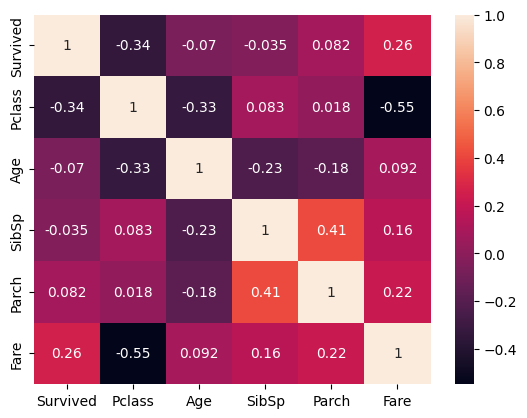

****************************************************************************************************
Liste des corrélations à analyser
****************************************************************************************************
Pclass > Fare : -0.549
SibSp > Parch : 0.415


In [393]:
df_corr=df[liste_float_int].corr()
sns.heatmap(df_corr,annot=True)
plt.show()
liste=[]
corr_check=[]
liste_corr=""
for i in range(len(df_corr)):
  for j in range(len(df_corr)):
    if (abs(df_corr.iloc[i,j])>=corr_limit)&(i<j):
        corr_check.append((str(df_corr.columns[i])+ " > " + str(df_corr.columns[j])+ " : " + str(round(df_corr.iloc[i,j],3))))
        liste_corr=liste_corr+str(df_corr.columns[i])+ " > " + str(df_corr.columns[j])+ " : " + str(round(df_corr.iloc[i,j],3))+'\n'
print("*"*100)
print("Liste des corrélations à analyser")
print("*"*100)
for cor in corr_check:
  print(cor)

resume=summary(resume,"EDA","corrélations à analyser",(liste_corr))

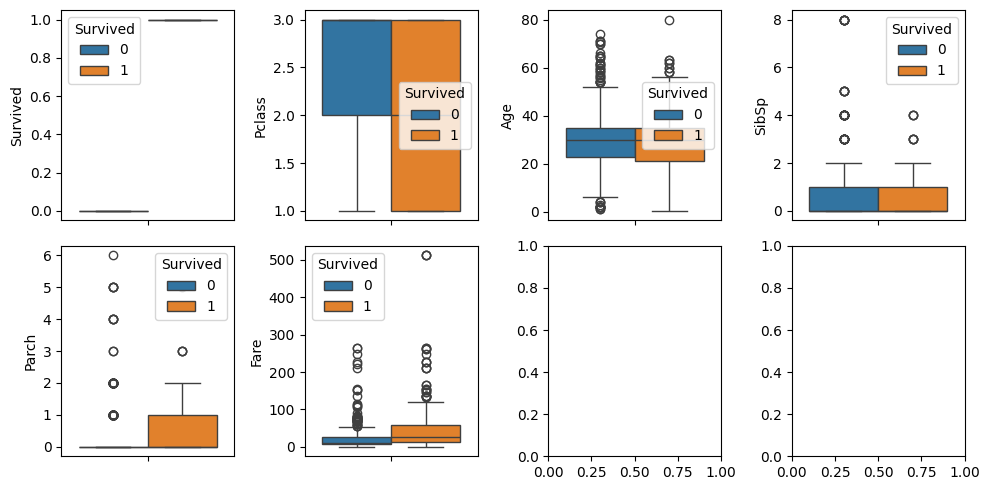

In [394]:
size=len(liste_float_int)
fig, axes = plt.subplots((size//4)+1, 4, figsize=(10, 5))
axes=axes.flatten()
for i, cols in enumerate(liste_float_int):
  sns.boxplot(data=df,y=cols,hue=cible,ax=axes[i])
  #axes[i].boxplot(df[cols])
  #axes[i].set_xlabel(cols)
plt.tight_layout()
plt.show()
resume=summary(resume,"EDA","Box plot sur les champs numériques","Box plot sur les champs numériques")

15


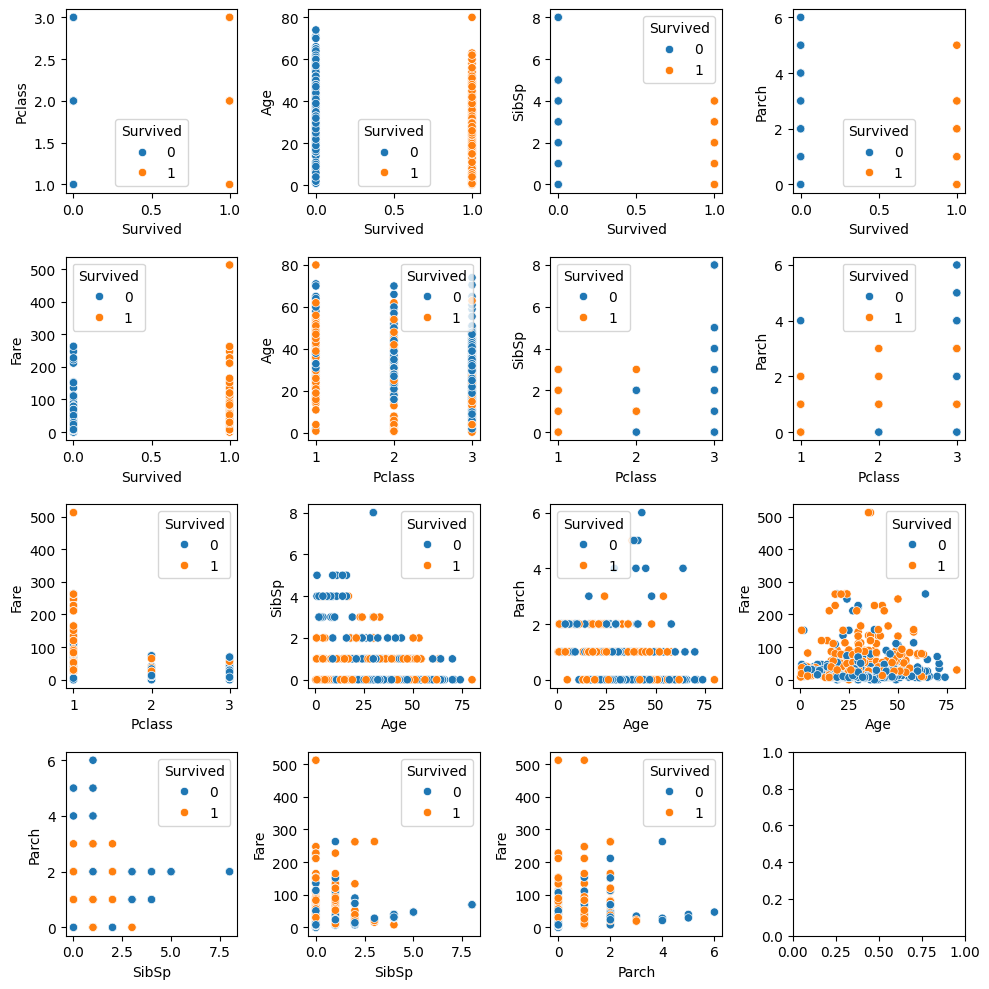

In [395]:
size=len(list(combinations(liste_float_int,2)))
print(size)
fig, axes = plt.subplots(max(size//4,1)+1, 4, figsize=(10, 10))
axes=axes.flatten()
for i, cols in enumerate(combinations(liste_float_int,2)):

  sns.scatterplot(data=df,x=cols[0],y=cols[1],hue=cible,ax=axes[i])

plt.tight_layout()
plt.show()
resume=summary(resume,"EDA","sns Scatter plot avec hue sur la cible","sns Scatter plot avec hue sur la cible")

## **Tests de proportion et d'indépendance**

###**Test du Chi-carré**
Test d'indépendance entre deux variables catégoriques.

Utilisé pour déterminer s'il y a une relation entre des variables catégorielles.
Python : scipy.stats.chi2_contingency

###**Test de Fisher**
Une alternative au Chi-carré pour les petits échantillons dans des tableaux de contingence 2x2.

Python : scipy.stats.fisher_exact

###**Test Z pour proportions**
Compare les proportions entre deux groupes.

Utilisé pour vérifier si les proportions de catégories dans des groupes sont égales.

##**Analyse VIF**

## **Sélection des caractéristiques**

### **Test du KHI2**
Ce test permet de :

### **Test ANOVA**

Compare les moyennes de plusieurs groupes pour une variable catégorielle.

Utilisé pour sélectionner des variables catégorielles qui ont un effet significatif sur une variable continue.
Python : sklearn.feature_selection.f_classif

### **Test de Kruskal Wilis**

Test non paramétrique pour comparer les distributions de plusieurs groupes.

Python : scipy.stats.kruskal

### **Test de Wilcoxon Mann Withey**

Test non paramétrique pour comparer des paires d'échantillons dépendants.

Python : scipy.stats.wilcoxon

### **Test de Friedman**
Version non paramétrique de l'ANOVA à mesures répétées.

Python : scipy.stats.friedmanchisquare

## **Tests de multicolinéarité**

### **Variance Inflation Factor (VIF)**
Mesure le niveau de corrélation entre une variable explicative et les autres variables explicatives d'un modèle.
Utilisé pour détecter la multicolinéarité.

Python : statsmodels.stats.outliers_influence.variance_inflation_factor

##**Vérifications des valeurs abérantes**

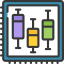

In [396]:
outliers=""
for col in liste_float_int:
  if df[col].nunique()>=5:
    inf=df[col].quantile(0.25)-1.5*iqr(df[col])
    sup=df[col].quantile(0.75)+1.5*iqr(df[col])
    df_outliers=df[(df[col]<inf) | (df[col]>sup)][col]
    outliers=outliers + "la colonne " + col + " contient "+ str(len(df_outliers))+ " outliers pour un iqr de " + str(iqr(df[col])) +'\n'
    df[col]=np.where(df[col]>sup,df[col].mean(),df[col])
    df[col]=np.where(df[col]<inf,df[col].mean(),df[col])
    print(df_outliers)
    print("*"*100)
resume=summary(resume,"EDA","valeurs aberantes avant correction",f"valeurs abérantes :"+"\n" + str(outliers))

7       2.00
11     58.00
15     55.00
16      2.00
33     66.00
       ...  
827     1.00
829    62.00
831     0.83
851    74.00
879    56.00
Name: Age, Length: 66, dtype: float64
****************************************************************************************************
7      3
16     4
24     3
27     3
50     4
59     5
63     3
68     4
71     5
85     3
88     3
119    4
159    8
164    4
171    4
176    3
180    8
182    4
201    8
229    3
233    4
261    4
266    4
278    4
324    8
341    3
374    3
386    5
409    3
480    5
485    3
541    4
542    4
634    3
642    3
683    5
686    4
726    3
787    4
792    8
813    4
819    3
824    4
846    8
850    4
863    8
Name: SibSp, dtype: int64
****************************************************************************************************
7      1
8      2
10     1
13     5
16     1
      ..
871    1
879    1
880    1
885    5
888    2
Name: Parch, Length: 213, dtype: int64
***************************************

In [397]:
outliers=""
for col in liste_float_int:
  if df[col].nunique()>=5:
    inf=df[col].quantile(0.25)-1.5*iqr(df[col])
    sup=df[col].quantile(0.75)+1.5*iqr(df[col])
    df[col]=np.where(df[col]>sup,sup,df[col])
    df[col]=np.where(df[col]<inf,inf,df[col])
    df_outliers=df[(df[col]<inf) | (df[col]>sup)][col]

    if len(df_outliers)>0:
      outliers= outliers + "la colonne " + col + " contient encore  "+ str(len(df_outliers))+ " outliers pour un iqr de " + str(iqr(df[col])) +'\n'
      print(df_outliers)
      print("*"*100)

resume=summary(resume,"EDA","valeurs aberantes après correction",f"valeurs abérantes :"+"\n" + str(outliers))

##**Transformation des données catégorielles**

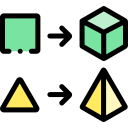

In [398]:
features=df.drop(cible, axis=1)
features=pd.get_dummies(features,columns=liste_cat,dtype=float, drop_first=True)

features_test=pd.get_dummies(df_test,columns=liste_cat,dtype=float, drop_first=True)
resume=summary(resume,"Data Preprocessing","transformation des données catégorielles",f"méthode utilisée: pd.get_dummies(...)")

In [399]:
features

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.000000,1.0,0.000000,7.250000,1.0,0.0,1.0
1,1,38.000000,1.0,0.000000,32.204208,0.0,0.0,0.0
2,3,26.000000,0.0,0.000000,7.925000,0.0,0.0,1.0
3,1,35.000000,1.0,0.000000,53.100000,0.0,0.0,1.0
4,3,35.000000,0.0,0.000000,8.050000,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
886,2,27.000000,0.0,0.000000,13.000000,1.0,0.0,1.0
887,1,19.000000,0.0,0.000000,30.000000,0.0,0.0,1.0
888,3,29.699118,1.0,0.381594,23.450000,0.0,0.0,1.0
889,1,26.000000,0.0,0.000000,30.000000,1.0,0.0,0.0


In [400]:

features=features.values
features_test=features_test.values
targets=df[cible].values

#**Division du Dataset**

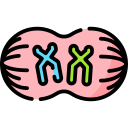

In [401]:


if fraction==0:
  X_train=features
  X_test=features
  y_train=targets
  y_test=targets
else:
  X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=fraction, random_state=seed)

resume=summary(resume,"Modelisation",f"Division en données {features.shape} d'entrainement et de test \n",f"proportion de test {X_test.shape} :{fraction}"+"\n"\
                + f"valeur de reproductibilité :{seed}")

#**Standardisation / Normalisation des données**

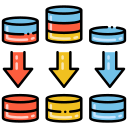

In [402]:
scaler = StandardScaler()
features = scaler.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
resume=summary(resume,"Data Preprocessing","Standardisation/Normalisation des données",f"méthode utilisée [sklearn]: StandardScaler(...)")

# **Transformation dimentionnelle**

## **ACF : Qualitatif**

## **T-SNE**

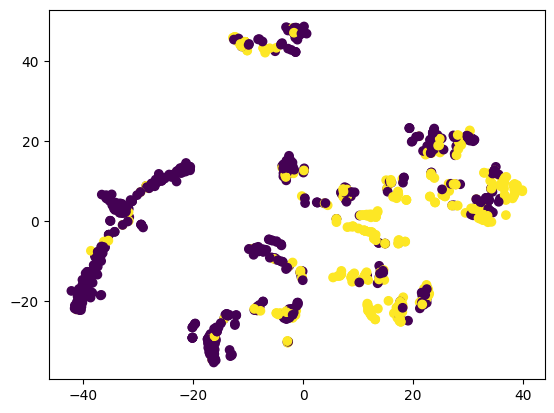

In [403]:
model_tsne = TSNE(learning_rate=100)
features_tsne = model_tsne.fit_transform(features)
xs = features_tsne[:,0]
ys = features_tsne[:,1]
plt.scatter(xs, ys, c=y_train)
plt.show()

resume=summary(resume,"Features Engineering","Réduction des dimensions via T-SNE",f"méthode utilisée [sklearn]: TSNE(...)")

## **PCA - Quantitatif** **texte en gras**

In [404]:
if pca==True:
  if dim_pca > 0:
    model_PCA=PCA(dim_pca)
  else:
    model_PCA=PCA()
  features_PCA=model_PCA.fit_transform(features)
  x_features=range(model_PCA.n_components_)
  plt.bar(x_features,model_PCA.explained_variance_)
  plt.show()
  print(model_PCA.explained_variance_)
  print(model_PCA.n_components_)
  resume=summary(resume,"Features Engineering","Réduction des dimensions via PCA et identification des dimensions intrinseques",f"méthode utilisée [sklearn]: PCA(...)")

  variance_cumulee = np.cumsum(model_PCA.explained_variance_ratio_)

  # Trouver le nombre de dimensions pour expliquer au moins var_pca % de la variance
  n_composantes = np.argmax(variance_cumulee >= var_pca) + 1
  print(f"Nombre de dimensions intrinsèques (pour {var_pca} de variance): {n_composantes}")

  resume=summary(resume,"Features Engineering","Réduction des dimensions via PCA et identification des dimensions intrinseques",f"{n_composantes} composantes principales expliquent {var_pca} de la variance des informations")

  model_PCA=PCA(n_composantes)
  features=model_PCA.fit_transform(features)
  X_train=model_PCA.transform(X_train)
  X_test=model_PCA.transform(X_test)
  features_test=model_PCA.transform(features_test)

## **REF**

## **Test du KHI2**

In [405]:
#raise Exception("Stop")

#**Modélisation**

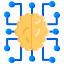

##**Initialisation du modèle**

##**Entrainement du modèle**

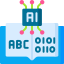

In [406]:
eval="selon la classification: 0 (positif) et 1 (négatif) \n \
L'utilisation des métriques d'évaluation dépend à la fois de l'équilibre dans les labels de classification \n\
et du coût des erreurs ; est-il plus coûteux d'obtenir des FP faux positifs ? est-il plus coûteux d'obtenir des FN faux négatifs?\n\
si on souhaite éviter des faux positifs (classer par erreur des 1 en 0) alors on privilégie la precision.\n\
si on souhaite éviter des faux négatifs (classer par erreur des 0 en 1) alors on privilégie le recall.\n\
s'il les deux types d'erreurs présentent le même coût alors on privilégie le f1-score (qui est réalité une moyenne hormonique de la precision et du recall).\n\
si nous avons un déséquilibre dans les labels de classification, le ROC-AUC permet de voir comment le modèle évolue dans la classification en fonction de l'application d'un taux de seuil probabiliste croissant. \n\
Ces taux de seuils probabilistes sont les différentes probabilités de classification produites par le model"

resume=summary(resume,"Modelisation","les règles d'évaluation",eval)

In [407]:
if len(modeles)>1:
  resume=summary(resume,"Modelisation",f"Analyses comparative de {len(modeles)} modèles","")
if validation_croisee==False:
  resume=summary(resume,"Modelisation","SANS Validation croisée","")
else:
  resume=summary(resume,"Modelisation","AVEC Validation croisée","")

evaluations=""
for nom, modele in modeles.items():
  if validation_croisee==False:
    modele.fit(X_train,y_train)
    resume=summary(resume,"Modelisation","Entrainement du modèle",modele)
    y_pred=modele.predict(X_test)
    y_pred_proba=modele.predict_proba(X_test)[:,1]
    predictions.append((nom,y_pred,y_pred_proba))
  else:
    grid_search = GridSearchCV(modele, modeles_grid[nom], cv=fold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train,y_train)
    resume=summary(resume,"Modelisation","paramètres du meilleur modèle", str(nom) +" : "+ str(grid_search.best_params_))
    y_pred=grid_search.predict(X_test)
    y_pred_proba=grid_search.predict_proba(X_test)[:,1]
    predictions.append((nom,y_pred,y_pred_proba))

  recall[nom]=recall_score(y_test,y_pred)
  precision[nom]=precision_score(y_test,y_pred)
  accuracy[nom]=accuracy_score(y_test,y_pred)
  f1score[nom]=f1_score(y_test,y_pred)

  evaluations=evaluations+ str(nom) +"  Recall "+str(round(recall[nom],3))+"\n"
  evaluations=evaluations+ str(nom) +"  F1-Score "+str(round(f1score[nom],3))+"\n"
  evaluations=evaluations+ str(nom) +"  Accuracy "+str(round(accuracy[nom],3))+"\n"
  evaluations=evaluations+ str(nom) +"  Precision "+str(round(precision[nom],3))+"\n"

resume=summary(resume,"Résultats","Analyse des scores",evaluations)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

##**Validation des hypothèses**

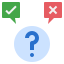

### **Tests de normalité des résidus**


#### **Test de Jarque-Bera**

Vérifie si les résidus d'un modèle suivent une distribution normale.

Python : scipy.stats.jarque_bera

####**Test de Lilliefors (KS ajusté)**
Une version modifiée du test de Kolmogorov-Smirnov pour tester la normalité des résidus.

Python : statsmodels.stats.diagnostic.lilliefors

### **Tests d'autocorrélation**

####**Test de Durbin-Watson**

Vérifie l'autocorrélation des résidus dans les modèles de régression.

Python : statsmodels.stats.stattools.durbin_watson

####**Test de Ljung-Box**
Teste l'absence d'autocorrélation dans les séries temporelles.

Python : statsmodels.stats.diagnostic.acorr_ljungbox

###**Tests d'hétéroscédasticité**

####**Test de Breusch-Pagan**
Vérifie la présence d'hétéroscédasticité (variance non constante des résidus).

Python : statsmodels.stats.diagnostic.het_breuschpagan

####**Test de White**
Test général d'hétéroscédasticité sans supposer une forme spécifique.

Python : statsmodels.stats.diagnostic.het_white

In [408]:
hypotheses="xxx"
resume=summary(resume,"Validation des hypothèses","Validation des hypothèses",hypotheses)

##**Evaluation du modèle**

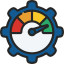

logreg


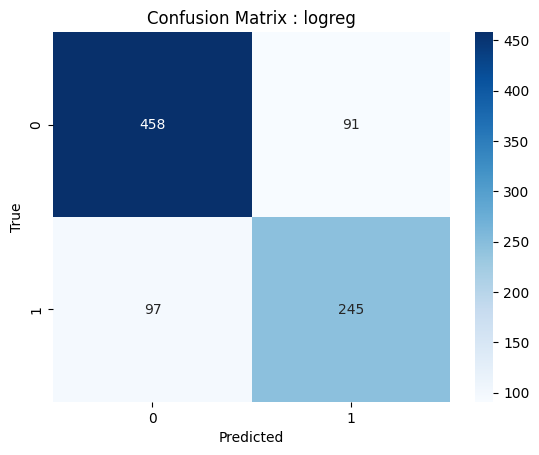

knn


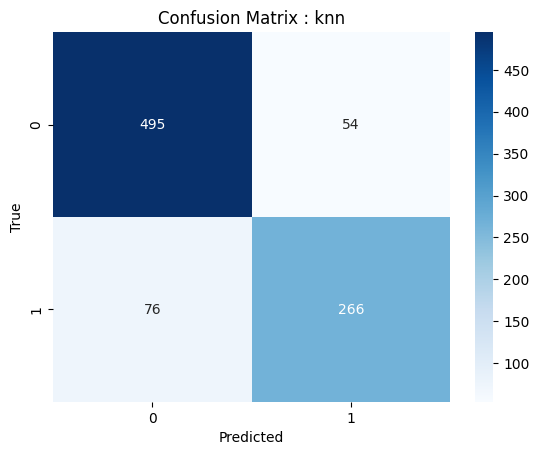

tree


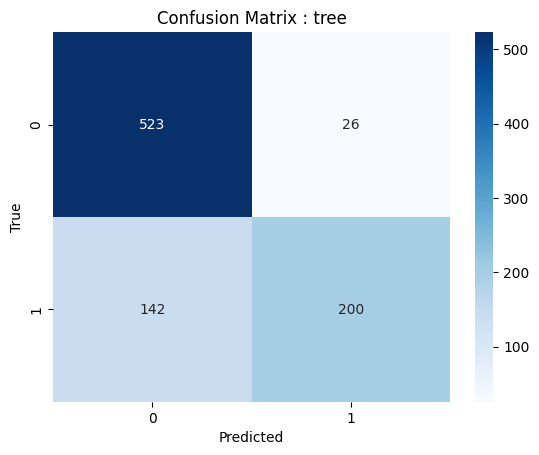

In [409]:
for val in predictions:
  print(val[0])
  cm = confusion_matrix(y_test, val[1])
  # Afficher la matrice de confusion avec seaborn
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix : '+ val[0])
  plt.show()
  resume=summary(resume,"Evaluation","Matrice de confusion : " + val[0],cm)


logreg


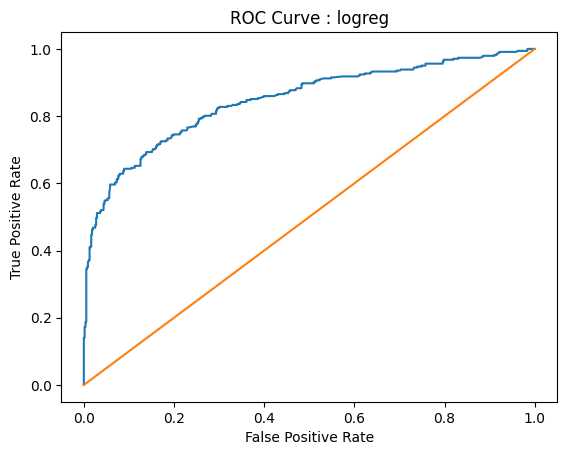

knn


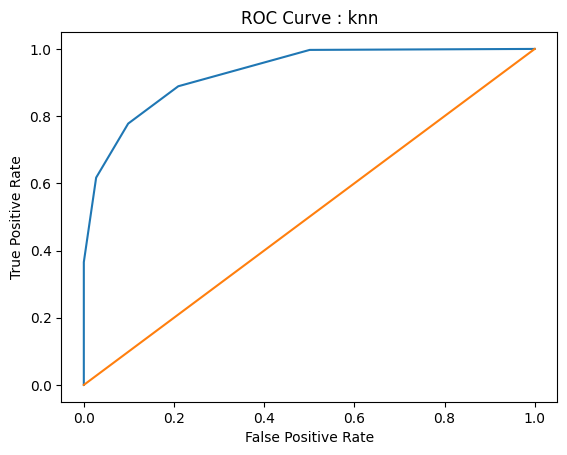

tree


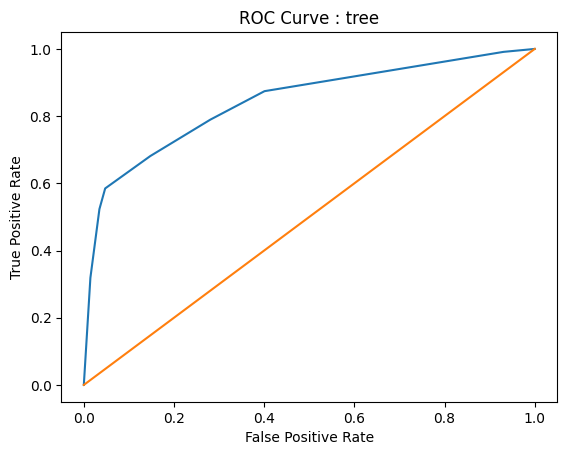

In [412]:
#print(y_pred)
#print(y_pred_proba)
best=""
scor=0
for val in predictions:
  fpr, tpr, thresholds = roc_curve(y_test, val[2])
  plt.plot(fpr, tpr)
  plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve : ' + val[0])
  plt.show()
  roc_auc = auc(fpr, tpr)

  if roc_auc > scor:
    scor=(round(roc_auc,3))
    best=val[0]

  resume=summary(resume,"Evaluation","Precision du modèle : " + val[0],str(round(roc_auc,3)))


In [413]:
X_test=features_test
for nom, modele in modeles.items():
  if nom==best:
    if validation_croisee==False:
      modele.fit(X_train,y_train)
      resume=summary(resume,"Modelisation","Entrainement du modèle pour Kaggle",modele)
      y_pred=modele.predict(X_test)
      y_pred_proba=modele.predict_proba(X_test)[:,1]
      predictions.append((nom,y_pred,y_pred_proba))
    else:
      grid_search = GridSearchCV(modele, modeles_grid[nom], cv=fold, scoring='accuracy', n_jobs=-1)
      grid_search.fit(X_train,y_train)
      resume=summary(resume,"Modelisation","paramètres du meilleur modèle", str(nom) +" : "+ str(grid_search.best_params_))
      y_pred=grid_search.predict(X_test)
      y_pred_proba=grid_search.predict_proba(X_test)[:,1]
      predictions.append((nom,y_pred,y_pred_proba))


In [414]:
print(y_pred)
submission = pd.DataFrame({
    'PassengerId': df_test_s['PassengerId'],
    'Survived': y_pred
})
submission.to_csv('/content/drive/My Drive/submission.csv', index=False)

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1
 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0
 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0
 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 0 0 1]


Interpretation du résultat

In [417]:
resume=summary(resume,"Inteprétation du résultat","Interprétation :",f" notre modèle a un score de {str(round(scor,3))} ce qui signifie que...")

#**Rapport**

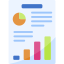

In [418]:
print_summary(resume)

****************************************************************************************************
================================RESULTATS: analyses et Modélisation=================================
****************************************************************************************************
+-----+---------------------------+---------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   1 | Section                   | libelle                                                       | information                                                                                                                                                                                                         |
+=====+===========================+==================================